In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
df_slot = pd.read_csv('gdoor_slot_performance.csv')
df_loc = pd.read_csv('gdoor_location.csv')

In [3]:
df_slot = df_slot.join(df_loc.set_index('City_ID'),on='City_ID')

In [4]:
df_slot.replace({'City_Name': {'\'': ''}}, regex=True, inplace=True)

In [5]:
df_slot.head()

,Employer_ID,City_ID,Contract_ID,StartDate,EndDate,Renewal_Flag,Job_Slots,Total_Contract_Value,Applications,Apply_Start_Clicks,Click_Market_Value,Job_Listings,City_Name,State_ID,State_Name
0,4277920,9767,2423796,10/30/2017,11/30/2017,1,15,995,215,255,15484.40,25,Kaser,NY,New York
1,2372987,8585,2074128,6/29/2017,7/29/2017,0,50,1495,55,70,1719.30,50,Mexico,PA,Pennsylvania
2,1142693,6665,1924740,5/2/2017,6/2/2017,0,15,495,45,95,1195.75,20,Seagoville,TX,Texas
3,1353893,5165,1942512,5/9/2017,6/6/2017,0,15,995,155,175,1197.35,20,Tyrone,PA,Pennsylvania
4,922427,3882,1380984,9/19/2016,10/20/2016,1,15,745,150,185,8889.70,20,Capitola,CA,California


In [6]:
#df_slot.to_csv('combined_slot_loc.csv',index=False)

[Text(0.5, 0, 'Renewal_Flag'),
 Text(1.5, 0, 'Job_Slots'),
 Text(2.5, 0, 'Total_Contract_Value'),
 Text(3.5, 0, 'Applications'),
 Text(4.5, 0, 'Apply_Start_Clicks'),
 Text(5.5, 0, 'Click_Market_Value'),
 Text(6.5, 0, 'Job_Listings')]

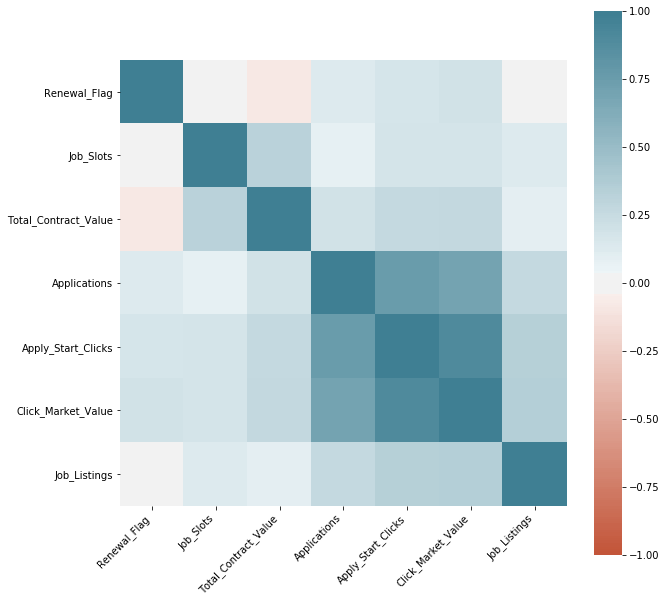

In [7]:
plt.figure(figsize=(10, 10))
corr = df_slot.iloc[:,3:].corr(method="spearman")
ax = sns.heatmap(
corr, 
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(20, 220, n=200),
square=True
)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=45,
horizontalalignment='right'
)

In [8]:
corr = df_slot.iloc[:,3:].corr(method="spearman")
corr.style.background_gradient(cmap="jet")

,Renewal_Flag,Job_Slots,Total_Contract_Value,Applications,Apply_Start_Clicks,Click_Market_Value,Job_Listings
Renewal_Flag,1.000000,-0.017485,-0.081339,0.121280,0.172325,0.190671,0.014706
Job_Slots,-0.017485,1.000000,0.324963,0.085290,0.181612,0.181753,0.129627
Total_Contract_Value,-0.081339,0.324963,1.000000,0.192514,0.261266,0.275513,0.091934
Applications,0.121280,0.085290,0.192514,1.000000,0.754749,0.702757,0.263458
Apply_Start_Clicks,0.172325,0.181612,0.261266,0.754749,1.000000,0.905095,0.346740
Click_Market_Value,0.190671,0.181753,0.275513,0.702757,0.905095,1.000000,0.352698
Job_Listings,0.014706,0.129627,0.091934,0.263458,0.346740,0.352698,1.000000


In [9]:
#Extracting Month df_slot
df_slot['StartDate'] = pd.to_datetime(df_slot['StartDate'])
df_slot['EndDate'] = pd.to_datetime(df_slot['EndDate'])

df_slot['StartMonth'] = df_slot['StartDate'].map(lambda x: x.month)
df_slot['EndMonth'] = df_slot['EndDate'].map(lambda x: x.month)

In [10]:
cols = df_slot.columns.tolist()
cols.remove('Renewal_Flag')
cols.append('Renewal_Flag')

df_slot = df_slot[cols]

In [11]:
#df_slot.to_csv('combined_slot_loc3.csv',index=False)

In [12]:
df_slot = df_slot.drop(['Employer_ID','City_ID','Contract_ID','StartDate','EndDate','City_Name','State_ID','State_Name'],axis=1)

In [13]:
#StartMonth EndMonth OneHotEncoding
df_slot0 = df_slot.iloc[:,:-3]
df_slot0 = pd.concat([df_slot0,pd.get_dummies(df_slot['StartMonth'], prefix='StartMonth')],axis=1)
df_slot0 = pd.concat([df_slot0,pd.get_dummies(df_slot['EndMonth'], prefix='EndMonth')],axis=1)
df_slot0 = pd.concat([df_slot0,df_slot.iloc[:,-1]],axis=1)
df_slot0.head()

,Job_Slots,Total_Contract_Value,Applications,Apply_Start_Clicks,Click_Market_Value,Job_Listings,StartMonth_1,StartMonth_2,StartMonth_3,StartMonth_4,...,EndMonth_4,EndMonth_5,EndMonth_6,EndMonth_7,EndMonth_8,EndMonth_9,EndMonth_10,EndMonth_11,EndMonth_12,Renewal_Flag
0,15,995,215,255,15484.40,25,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50,1495,55,70,1719.30,50,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,15,495,45,95,1195.75,20,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,15,995,155,175,1197.35,20,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,15,745,150,185,8889.70,20,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [21]:
#Split Train-Test

k = 0.7
leng = int(k*len(df_slot))
df_train = df_slot0.iloc[0:leng,:]
df_test = df_slot0.iloc[leng:,:]

#ANN
print("-----------------------ANN---------------------------")
clf = MLPClassifier(solver='adam', activation='logistic', alpha=1e-5,hidden_layer_sizes=( 14, 5, 3), random_state=1)
y_pred = clf.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])

y_pred_val = y_pred.predict(df_test.iloc[:,:-1])
y_pred_val_proba = y_pred.predict_proba(df_test.iloc[:,:-1])

print(confusion_matrix(df_test.iloc[:,-1],y_pred_val))
print(classification_report(df_test.iloc[:,-1],y_pred_val))

#Decision Tree
print("-----------------------Decision Tree---------------------------")

clf = DecisionTreeClassifier(class_weight={0:2,1:1},random_state=1)
y_pred = clf.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])

y_pred_val = y_pred.predict(df_test.iloc[:,:-1])
y_pred_val_proba = y_pred.predict_proba(df_test.iloc[:,:-1])

print(confusion_matrix(df_test.iloc[:,-1],y_pred_val))
print(classification_report(df_test.iloc[:,-1],y_pred_val))

-----------------------ANN---------------------------
[[1496 1864]
 [ 776 7192]]
              precision    recall  f1-score   support

           0       0.66      0.45      0.53      3360
           1       0.79      0.90      0.84      7968

    accuracy                           0.77     11328
   macro avg       0.73      0.67      0.69     11328
weighted avg       0.75      0.77      0.75     11328

-----------------------Decision Tree---------------------------
[[1714 1646]
 [1537 6431]]
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      3360
           1       0.80      0.81      0.80      7968

    accuracy                           0.72     11328
   macro avg       0.66      0.66      0.66     11328
weighted avg       0.72      0.72      0.72     11328

